# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

### Model description

- Model architecture: Xception
- Fractal module used: None 
- Number of layers tuned: 2

### Load the ISIC Archive dataset

In [3]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [4]:
class LesionClassifier(tf.keras.Model):
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.inside_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.inside_model.layers:
            if layer.name in ['block14_sepconv1','block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False            
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        outputs = self.inside_model(inputs)
        outputs = self.dense(outputs)
        
        return outputs

In [5]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [6]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [7]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [8]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [9]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
947/947 [==============================] - ETA: 0s - loss: 0.7638 - accuracy: 0.7430
Epoch 1: val_loss improved from inf to 0.72686, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 8257s 9s/step - loss: 0.7638 - accuracy: 0.7430 - val_loss: 0.7269 - val_accuracy: 0.7469
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.7715
Epoch 2: val_loss improved from 0.72686 to 0.65572, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 7443s 8s/step - loss: 0.6610 - accuracy: 0.7715 - val_loss: 0.6557 - val_accuracy: 0.7757
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.7877
Epoch 3: val_loss improved from 0.65572 to 0.63863, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 6378s 7s/step - loss: 0.6119 - accuracy: 0.7877 - val_loss: 0.6386 - val_accuracy: 0.7827
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.7989
Epoch 4: val_loss did not improve from 0.63863
947/947 [==============================] - 5484s 6s/step - loss: 0.5766 - accuracy: 0.7989 - val_loss: 0.6476 - val_accuracy: 0.7810
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.8092
Epoch 5: val_loss improved from 0.63863 to 0.61773, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4906s 5s/step - loss: 0.5436 - accuracy: 0.8092 - val_loss: 0.6177 - val_accuracy: 0.7938
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.8169
Epoch 6: val_loss improved from 0.61773 to 0.61616, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4238s 4s/step - loss: 0.5136 - accuracy: 0.8169 - val_loss: 0.6162 - val_accuracy: 0.7958
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.8255
Epoch 7: val_loss improved from 0.61616 to 0.61595, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4197s 4s/step - loss: 0.4893 - accuracy: 0.8255 - val_loss: 0.6160 - val_accuracy: 0.8003
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.8315
Epoch 8: val_loss improved from 0.61595 to 0.60066, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4052s 4s/step - loss: 0.4664 - accuracy: 0.8315 - val_loss: 0.6007 - val_accuracy: 0.8012
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 0.4452 - accuracy: 0.8396
Epoch 9: val_loss did not improve from 0.60066
947/947 [==============================] - 11196s 12s/step - loss: 0.4452 - accuracy: 0.8396 - val_loss: 0.6124 - val_accuracy: 0.8040
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8480 
Epoch 10: val_loss did not improve from 0.60066
947/947 [==============================] - 12329s 13s/step - loss: 0.4254 - accuracy: 0.8480 - val_loss: 0.6364 - val_accuracy: 0.7971
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8531
Epoch 11: val_loss did not improve from 0.60066
947/947 [==============================] - 12392s 13s/step - loss: 0.4069 - accuracy: 0.8531 - val_loss: 0.6260 - val_accuracy: 0.8045
Epoch 12/30
947/947 [=======

INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 16266s 17s/step - loss: 0.3930 - accuracy: 0.8569 - val_loss: 0.5997 - val_accuracy: 0.8050
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.8643 
Epoch 13: val_loss did not improve from 0.59966
947/947 [==============================] - 19965s 21s/step - loss: 0.3763 - accuracy: 0.8643 - val_loss: 0.6094 - val_accuracy: 0.8098


### Testing

In [10]:
model.load_weights(checkpoint_path)

In [11]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [12]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 266s 2s/step


In [13]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [14]:
auc_metric

{'actinic keratosis': 0.9575734223820532,
 'basal cell carcinoma': 0.969754860240442,
 'dermatofibroma': 0.9006151799817109,
 'melanoma': 0.9070619415857512,
 'nevus': 0.9503492699655881,
 'pigmented benign keratosis': 0.962318033015254,
 'seborrheic keratosis': 0.9281279076391394,
 'solar lentigo': 0.9684044748560878,
 'squamous cell carcinoma': 0.9449817375609341,
 'vascular lesion': 0.98473943975834}

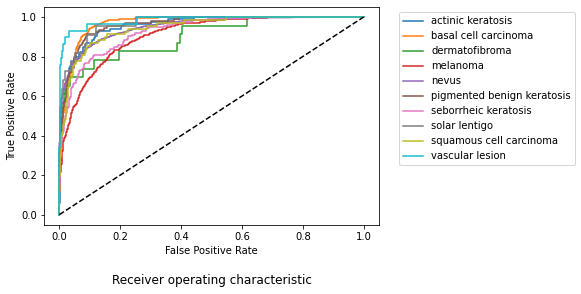

In [15]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [16]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

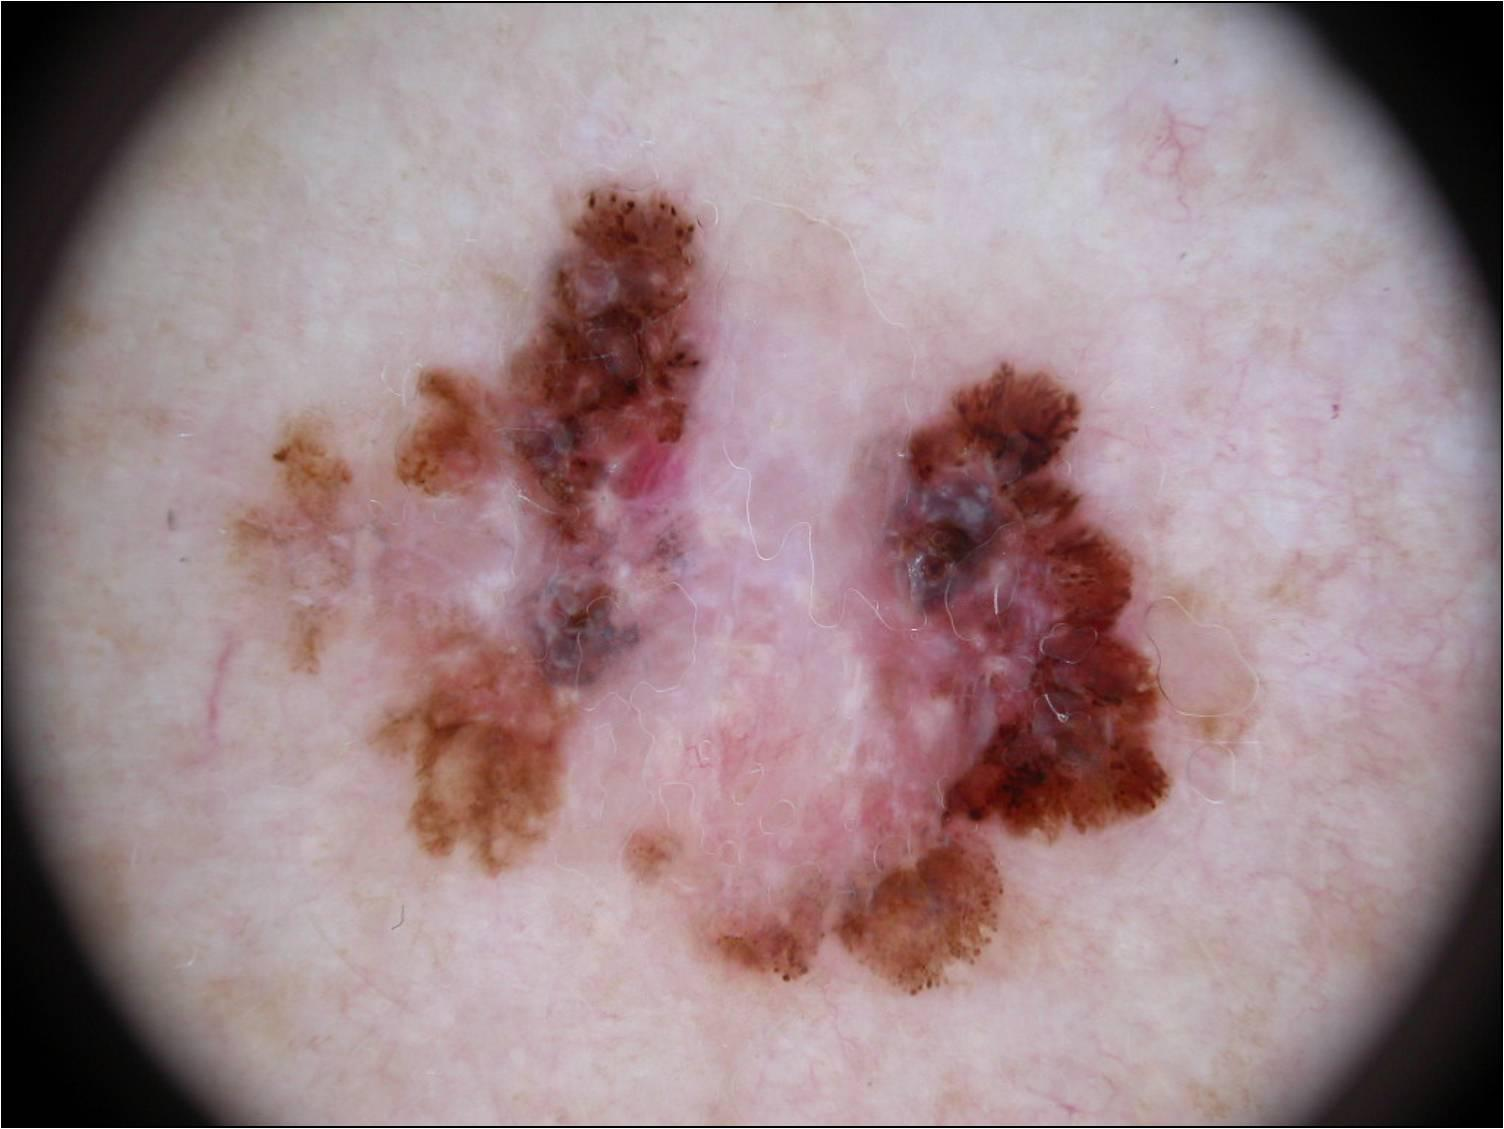

In [17]:
display(Image(melanoma_im_path, width=600))

In [18]:
img_array = tf.keras.applications.xception.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [19]:
heatmap = make_gradcam_heatmap(img_array, model.inside_model, 'block14_sepconv2')

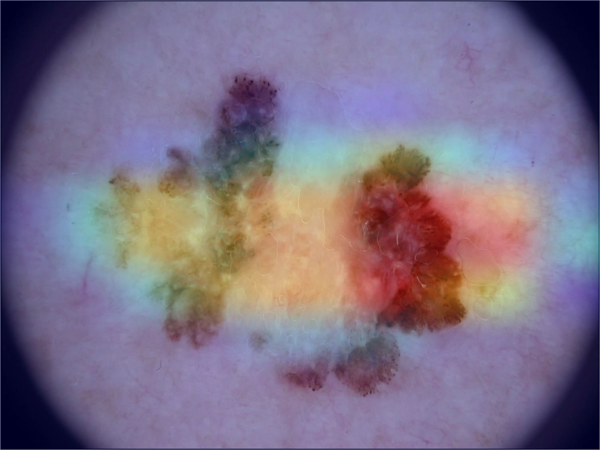

In [20]:
display_gradcam(melanoma_im_path, heatmap)